In [58]:
# Import libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [59]:
# Data pre-processing functions

def data_dummifier(dataframe: pd.DataFrame, columns: list) -> pd.DataFrame:
    '''Encodes from columns selected'''
    return pd.get_dummies(dataframe, prefix='', prefix_sep='', columns=columns)


def extract_categories(series: pd.Series, sep=';') -> list:
    ''' Extract categories of nested elements'''
    series = series.astype('str')
    elements = []
    for element in series:
        elements.extend(element.strip('[]').split(sep))
    return list(set(elements))

def advanced_encoding(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    '''Encoding for UNIQUE nested values inside one element'''
    val_names = extract_categories(df[col_name])
    df[col_name] = df[col_name].astype('str')
    for val in val_names:
        df[val] = df[col_name].str.contains(val).map({True: 1, False: 0})
    return df.drop(col_name, axis=1)



In [60]:
# import data from local filesystem

micro_and_gen = pd.read_csv('raw_data/sensibilidad.csv')
phys_chem = pd.read_csv('raw_data/fisicoquimica.csv')

# add sampling site to micro_and_gen df
micro_and_gen['Sampling site'] = micro_and_gen.ID.apply(lambda x: x[0])

In [61]:
# encode categorical variables for analysis and separate by species

encoded_df = data_dummifier(micro_and_gen, columns=['Species', 'Sampling site']).set_index('ID')

for column in ['Genotipo', 'Fenotipo']:
    encoded_df = advanced_encoding(df=encoded_df, col_name=column)

encoded_df.head()

,A.baumannii,E.asburiae,E.cloacae,E.coli,K.pneumoniae,A,B,TEM,SHV,KPC,...,MER,LEVO,ERT,AMP,PIME,GM,TS,CFZ,AMC,IMP
ID,,,,,,,,,,,,,,,,,,,,,
AI6,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
AI10,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
AI11,1,0,0,0,0,1,0,0,0,0,...,1,1,0,0,1,1,1,0,0,1
AI12,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
AC1,0,0,0,1,0,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0


In [62]:
# encode data
encoded_df = data_dummifier(micro_and_gen, columns=['Species', 'Sampling site'])

# nested encoding
for column in ['Genotipo', 'Fenotipo']:
    encoded_df = advanced_encoding(df=encoded_df, col_name=column)

# set ID as index
encoded_df.set_index('ID', inplace=True)

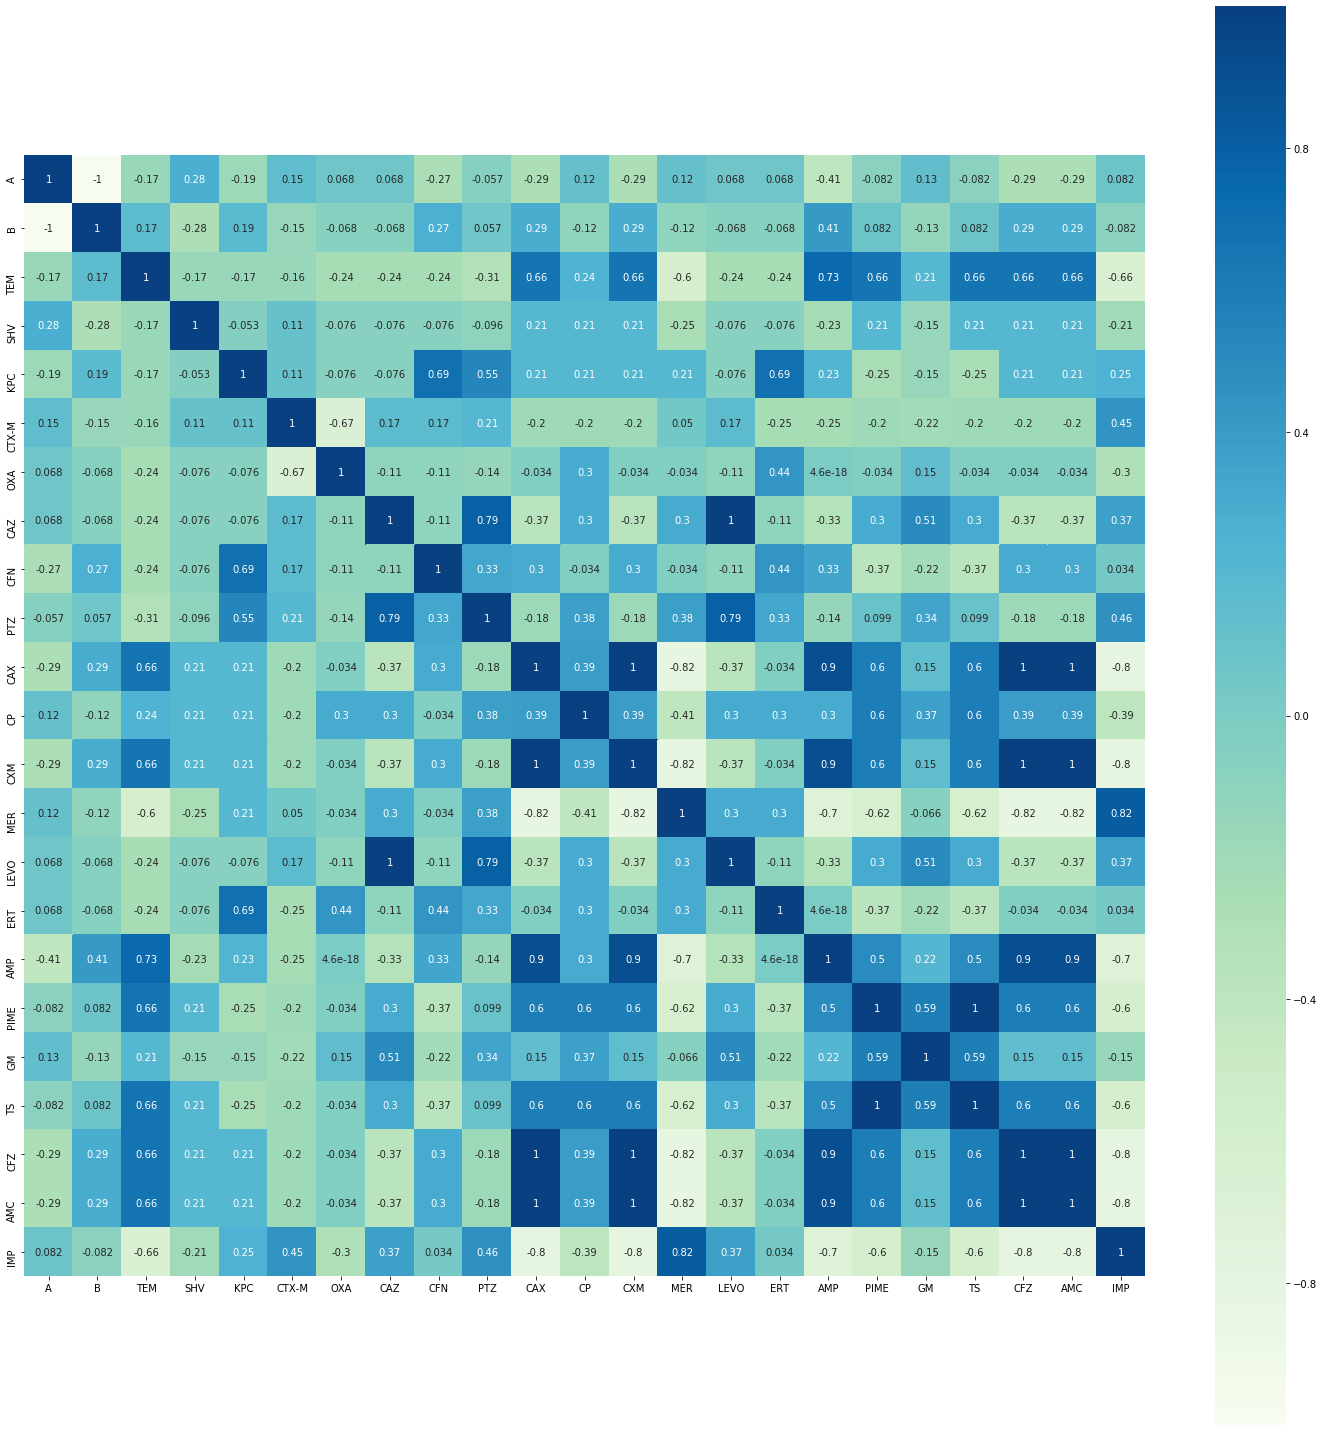

In [63]:
# genetic data and phenotypic data
genetic_data = encoded_df.iloc[:, 5:]
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(genetic_data.corr(), vmin=-1, vmax=1, cmap='GnBu', annot=True, ax=ax, square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
# ax.set_title('Correlation heatmap of sample features', fontsize=30)
plt.tight_layout()
plt.savefig('visualizations/' + 'feature_corr_heatmap_corr.png', dpi=320)

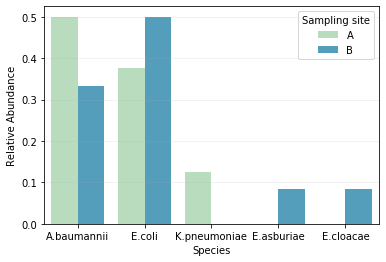

In [64]:
# Configure Plot
name = 'args_distribution.png'
_, ax = plt.subplots()
ax.grid(True, alpha=0.2)

# ARGS data
bact_site = micro_and_gen.iloc[:, :6][['Species', 'Sampling site']]
data = pd.DataFrame(bact_site.groupby('Sampling site')['Species'].value_counts(normalize=True))
data.columns = ['Relative Abundance']
data.reset_index(inplace=True)

# Plot data from site A
sns.barplot(x='Species', y='Relative Abundance', hue='Sampling site', 
            data=data, ax=ax, palette='GnBu')

# ax.set_title('Clinically important isolates by sampling site')
# Save figure
plt.savefig('visualizations/' + 'bacterial_distribution.png', dpi=320)

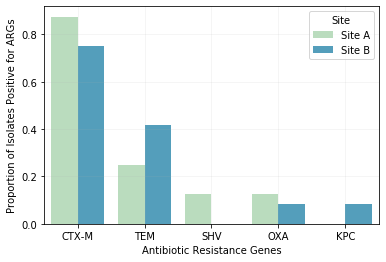

In [65]:
args = encoded_df.iloc[:, 5:12]
df = args.groupby('A').mean().T.iloc[1:, :].reset_index()
df.columns = ['Genes', 'Site B', 'Site A']
df = df[['Genes', 'Site A', 'Site B']]
df = df.melt(id_vars='Genes', var_name='Site', value_name='Frequency')
df = df.sort_values('Frequency', ascending=False)
ax = sns.barplot(x='Genes', y='Frequency', hue='Site', data=df, palette='GnBu')
ax.grid(True, alpha=0.15)
# plt.title('Antibiotic resistance genes by sampling site')
plt.ylabel('Proportion of Isolates Positive for ARGs')
plt.xlabel('Antibiotic Resistance Genes')
plt.savefig('visualizations/' + 'args_distribution.png', dpi=320)

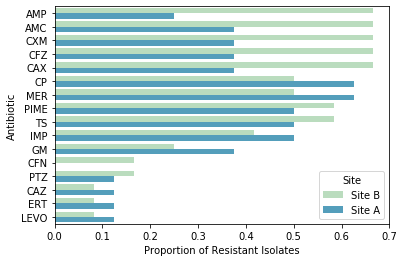

In [66]:
resis = encoded_df.iloc[:, 12:].reset_index()
resis['Site'] = resis.ID.apply(lambda x: x[0])
resis.drop('ID', inplace=True, axis=1)

df = resis.groupby('Site')[resis.columns[:-1]].mean().T.reset_index()
df.columns = ['Phenotypes', 'Site A', 'Site B']
df = df.melt(id_vars='Phenotypes', var_name='Site', value_name='Frequency')
df.sort_values('Frequency', ascending=False, inplace=True)

ax = sns.barplot(y='Phenotypes', x='Frequency', hue='Site', data=df, palette='GnBu')
plt.xlabel('Proportion of Resistant Isolates')
plt.ylabel('Antibiotic')
# plt.title('Resistance phenotype by sampling site')
plt.savefig('visualizations/' + 'resistance_distribution.png', dpi=320)

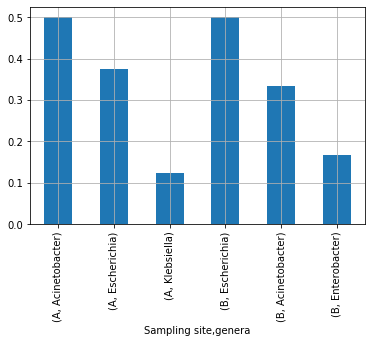

In [67]:
micro_and_gen.groupby('Sampling site').count()
df = micro_and_gen.copy()
df['genera'] = df.Species.map(
    {
        'A.baumannii': 'Acinetobacter',
        'E.coli': 'Escherichia',
        'K.pneumoniae': 'Klebsiella',
        'E.asburiae': 'Enterobacter',
        'E.cloacae': 'Enterobacter'
    }
)
samples = df.groupby('Sampling site')['genera'].value_counts(normalize=True)
samples.plot(kind='bar', grid=True)

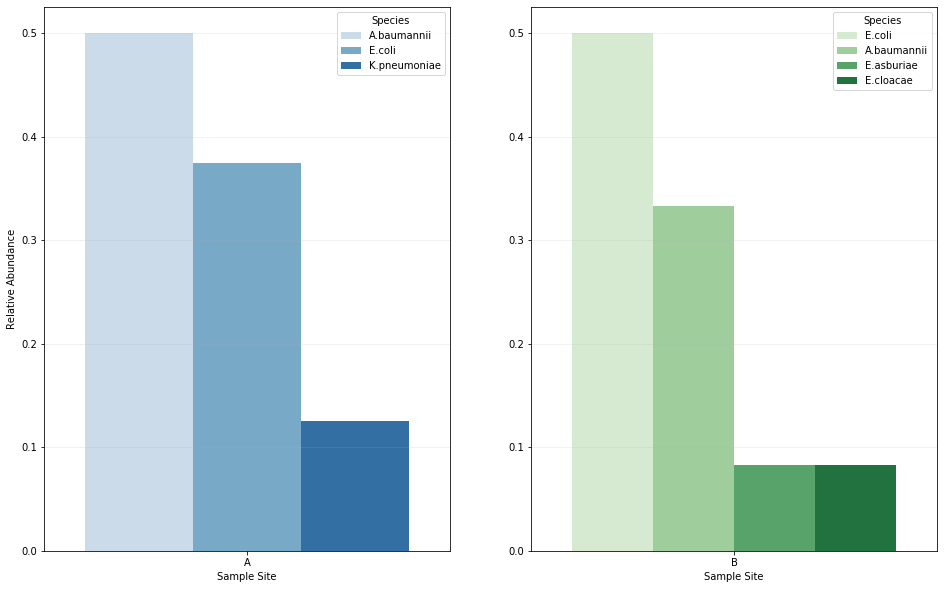

In [68]:
# Config figure and subplots
name = 'alt_bact_distrib.png'

_, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 10), sharey=False)

for ax in axes:
    ax.grid(True, alpha=0.2)

# Frequency of each bacteria
bact_dist = micro_and_gen.groupby(
    'Sampling site')['Species'].value_counts(
        sort=True, normalize=True).unstack().T.reset_index()

# Melt dataframe to reshape
bact_dist = pd.melt(
    frame=bact_dist,
    id_vars='Species',
    var_name='Sample Site',
    value_name='Relative Abundance'
)

# Reshaped and ordered dataframe
bact_dist = bact_dist.sort_values(
    ['Sample Site', 'Relative Abundance'], ascending=False).dropna().groupby(
        'Species').head(10)

# Data from each site
data_a = bact_dist[bact_dist['Sample Site'] == 'A']
data_b = bact_dist[bact_dist['Sample Site'] == 'B']

# Plot data from site A
sns.barplot(x='Sample Site', y='Relative Abundance', hue='Species',
            ax=axes[0], palette='Blues', hue_order=data_a.Species, data=data_a)

# Plot data from site B
sns.barplot(x='Sample Site', y='Relative Abundance', hue='Species',
            ax=axes[1], palette='Greens', hue_order=data_b.Species, data=data_b)

# Erase data from second yaxis
plt.ylabel('')

# Save figure
plt.savefig('visualizations/' + name, dpi=320)